# **CUSTOMER SEGMENTATION - RFM ANALYSIS**

**Objective:**

Pada notebook ini akan dilakukan proses segmentasi pelanggan berdasarkan data histori transaksi e-commerce. Metode segmentasi pelanggan akan dilakukan menggunakan metrics RFM dengan pengombinasian model K-Means.

Dataset yang digunakan pada notebook ini dapat diakses pada [link](https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business?resource=download).

## **IMPORT LIBRARY**

In [1]:
## install feature-engine for Winsorizer (capping outlier)

# !pip install feature-engine

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.transformation import LogTransformer
from sklearn.preprocessing import MinMaxScaler


from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer

import warnings
warnings.filterwarnings(action='ignore')

## **DATA LOADING AND OVERVIEW**

In [3]:
# !unzip Sales_Transaction.zip

In [4]:
# load data
df = pd.read_csv('/content/Sales Transaction v.4a.csv')
df.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom


In [5]:
# overview each columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


In [6]:
# checking missing values
df.isnull().sum()

TransactionNo     0
Date              0
ProductNo         0
ProductName       0
Price             0
Quantity          0
CustomerNo       55
Country           0
dtype: int64

In [7]:
# checking for duplicated data
df[df.duplicated()].shape

(5200, 8)

In [8]:
# checking basic statistics and anomalies for numeric columns
df.describe()

,Price,Quantity,CustomerNo
count,536350.000000,536350.000000,536295.000000
mean,12.662182,9.919347,15227.893178
std,8.490450,216.662300,1716.582932
min,5.130000,-80995.000000,12004.000000
25%,10.990000,1.000000,13807.000000
50%,11.940000,3.000000,15152.000000
75%,14.090000,10.000000,16729.000000
max,660.620000,80995.000000,18287.000000


Kesimpulan:
- Kolom `Date` memiliki format `object`, perlu dirubah menjadi `datetime`.
- Terdapat 55 missing data pada kolom `CustomerNo`.
- Terdapat 5200 data duplikat.
- Berdasarkan `.describe()` diketahui terdapat nilai negatif pada quantity

Ke-empat hal tersebut akan ditindaklanjuti pada section data cleaning.

## **Data Cleaning**

Objective pada section data cleaning ialah untuk mentrasformasikan data histori transaksi menjadi bentuk agregasi RFM metrics per pelanggan.

Tahapan yang akan dilakukan antara lain:
1. Drop missing values berdasarkan kolom `CutomerNo`.
2. Drop data duplikat.
3. Convert format kolom `Date` menjadi datetime.
4. Memfilter data menjadi rentang periode 1 tahun.
5. Drop value `Quantity` dibawah sama dengan 0.
6. Membuat kolom `Total_Price`
7. Melakukan Agregasi RFM metrics per pelanggan:
    - Recency       : Jarak hari transaksi terakhir pelanggan dari batas akhir periode waktu.
    - Frequency     : Frekuensi belanja pelanggan dalam rentang periode waktu 1 tahun.
    - Mean_Monetary : Rata-rata spending pelanggan disetiap transaksi.


In [9]:
# 1. drop missing values based CustomerNo
df.dropna(inplace=True)

In [10]:
# 2. drop duplicated data
df.drop_duplicates(inplace=True)

In [11]:
# 3. Converting Date format
df['Date'] = pd.to_datetime(df['Date'])

# Checking Date range
a = str(df['Date'].dt.date.min())
b = str(df['Date'].dt.date.max())
print(f'Available date ranged from {a} to {b}')

Available date ranged from 2018-12-01 to 2019-12-09


In [12]:
# 4. Filter Data so we have 1 year time period
df = df[df['Date'] < '2019-12-01']

a = str(df['Date'].dt.date.min())
b = str(df['Date'].dt.date.max())
print(f'Filtered date ranged from {a} to {b}')

Filtered date ranged from 2018-12-01 to 2019-11-30


In [13]:
# 5. Drop quantity below zero
df = df[df['Quantity'] > 0]

In [14]:
# 6. Create Total_Price column
df['Total_Price'] = df['Price'] * df['Quantity']
df.head(4)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Total_Price
25361,579522,2019-11-30,84879,Assorted Colour Bird Ornament,6.04,8,14432.0,United Kingdom,48.32
25362,579522,2019-11-30,82486,3 Drawer Antique White Wood Cabinet,6.04,4,14432.0,United Kingdom,24.16
25363,579522,2019-11-30,82483,Wood 2 Drawer Cabinet White Finish,6.04,8,14432.0,United Kingdom,48.32
25364,579522,2019-11-30,23493,Vintage Doily Travel Sewing Kit,6.04,10,14432.0,United Kingdom,60.40


In [15]:
# 7.a. Create Recency representative
df['recency'] = (pd.to_datetime('2019-12-01') - df['Date']) / np.timedelta64(1, 'D')

df.sample(4)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Total_Price,recency
324437,555516,2019-06-05,22652,Travel Sewing Kit,11.94,6,17706.0,United Kingdom,71.64,179.0
252956,562114,2019-08-02,85053,French Enamel Candleholder,14.48,1,13114.0,United Kingdom,14.48,121.0
143171,571239,2019-10-14,23284,Doormat Keep Calm And Come In,17.51,10,12744.0,Singapore,175.10,48.0
275355,560024,2019-07-14,84508B,Stripes Design Teddy,12.86,1,15005.0,United Kingdom,12.86,140.0


In [16]:
# 7. Aggregating data based on RFM metrics
df_rfm = df.groupby(['CustomerNo']).agg({"recency":min,
                                "TransactionNo":pd.Series.nunique,
                                "Total_Price": sum})

df_rfm.columns = ['recency', 'frequency', 'total_monetary']
df_rfm

,recency,frequency,total_monetary
CustomerNo,,,
12004.0,219.0,1,1509.60
12006.0,210.0,1,24.76
12008.0,268.0,1,5689.57
12013.0,351.0,1,69.96
12024.0,168.0,1,149.52
...,...,...,...
18280.0,269.0,1,623.26
18281.0,172.0,1,576.58
18282.0,118.0,1,871.54


Pada grouping diatas, representasi `monetary` masih dalam bentuk total spending dalam 1 tahun. Agar mendapatkan representasi rerata spending tiap transaksi, perlu diolah lebih lanjut pada kode berikut:

In [17]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4671 entries, 12004.0 to 18287.0
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         4671 non-null   float64
 1   frequency       4671 non-null   int64  
 2   total_monetary  4671 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 146.0 KB


Pada tahapan ini kita telah berhasil mentransformasikan data histori transaksi menjadi data agregasi RFM metrics per pelanggan.

## **EDA MODELING AND PREPROCESSING**

In [18]:
# checking descriptive statistics and anomaly
df_rfm.describe()

,recency,frequency,total_monetary
count,4671.000000,4671.000000,4.671000e+03
mean,95.355170,4.061657,1.290285e+04
std,100.121241,7.121585,5.161869e+04
min,1.000000,1.000000,5.970000e+00
25%,17.000000,1.000000,1.824365e+03
50%,52.000000,2.000000,4.742460e+03
75%,154.000000,4.000000,1.170932e+04
max,365.000000,198.000000,2.061833e+06


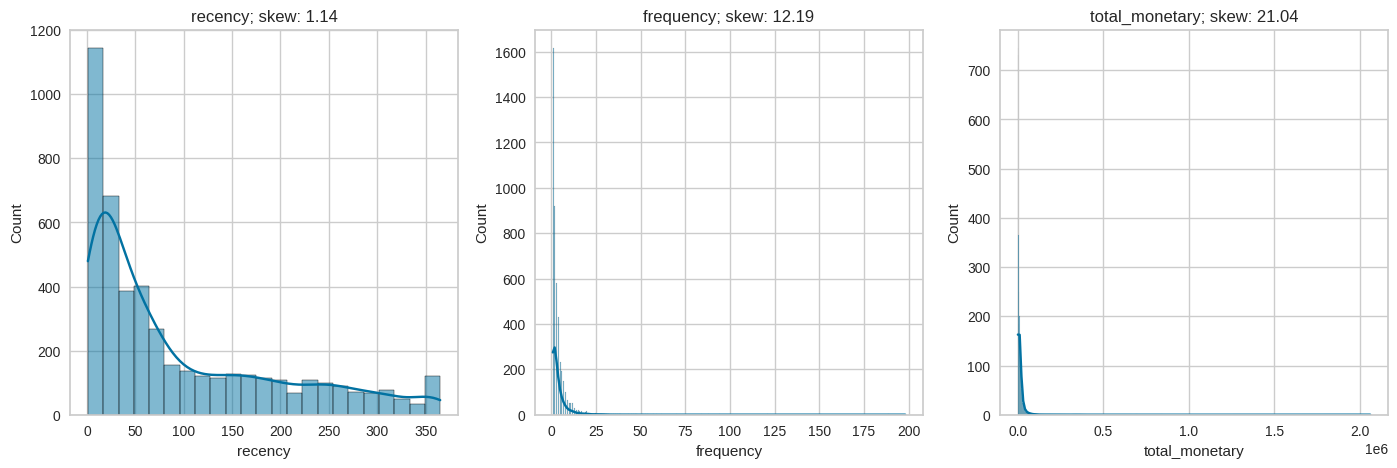

In [19]:
fig, ax = plt.subplots(ncols=3, figsize=[17,5])
ax = ax.flatten()

for idx, i in enumerate(df_rfm.columns):
  sns.histplot(df_rfm[i], ax=ax[idx], kde=True)
  ax[idx].set_title(f'{i}; skew: {df_rfm[i].skew().round(2)}')

Berdasarkan informasi `.describe()` dan visualisasi histogram diketahui:
- Recency: memiliki rentang dari 1 sampai 365 yang telah sesuai dengan yang di-inginkan.
- Frequency: Memiliki skew yang tinggi (12.19) ditandai dengan jarak antara Q3 dengan nilai maksimum yang sangat jauh.
- Mean_Monetary: Memiliki skew yang tinggi (53.36) ditandai dengan jarak antara Q3 dengan nilai maksimum yang sangat jauh.

Sebagai upaya dalam menghandling outlier pada kolom`frequency` dan `total_monetary`, akan dilakukan transformasi sebaran log.

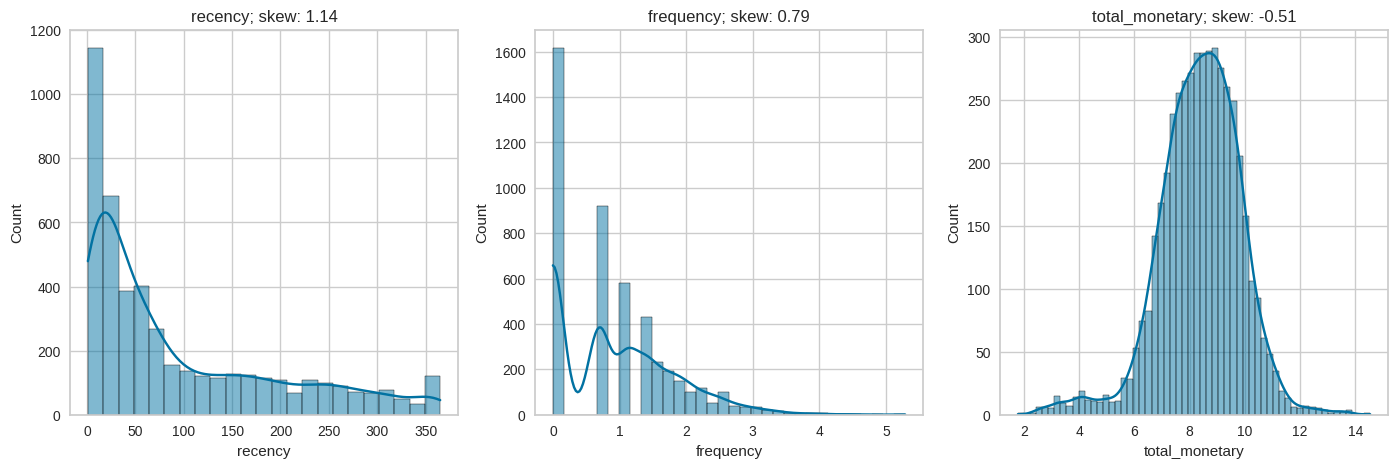

In [20]:
logt = LogTransformer(variables=['frequency', 'total_monetary'])
X = pd.DataFrame(logt.fit_transform(df_rfm))
X.columns = ['recency', 'frequency', 'total_monetary']

fig, ax = plt.subplots(ncols=3, figsize=[17,5])
ax = ax.flatten()

for idx, i in enumerate(X.columns):
  sns.histplot(X[i], ax=ax[idx], kde=True)
  ax[idx].set_title(f'{i}; skew: {X[i].skew().round(2)}')

Keberadaan outlier pada kolom `frequency` dan `total_monetary` sudah lebih berkurang walaupun tidak sepenuhnya.

Selanjutnya dilakukan proses scaling untuk menyamakan orde magnitude dari ketiga variable. MinMax Scaler mengingat sebaran pada kolom `recency` dan `frequency` tidak normal.

In [21]:
# Scaling
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = ['recency', 'frequency', 'total_monetary']

Hingga tahap ini, Pemrosesan data input ke model sudah selesai dilakukan. Berikut perbandingan visualisasi data original dan preprocessed, yang akan digunakan dalam pembuatan model clustering:

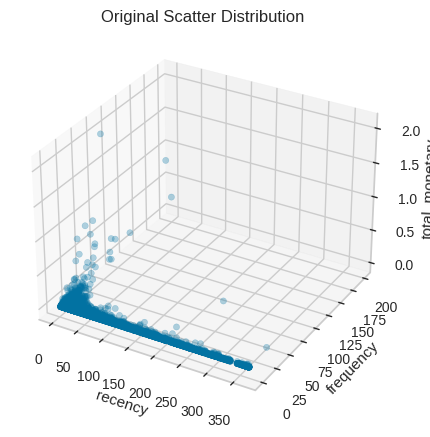

<Figure size 800x550 with 0 Axes>

In [22]:
# 3D scatterplot - Original Data Distribution
plt.figure(figsize=(5,5))

ax = plt.subplot(111, projection='3d')
ax.scatter(df_rfm['recency'], df_rfm['frequency'], df_rfm['total_monetary'],
           marker="o", alpha=.3)

ax.set_xlabel("recency")
ax.set_ylabel("frequency")
ax.set_zlabel("total_monetary")

plt.title('Original Scatter Distribution')
plt.show()

plt.savefig('Before Capping and Scaling.jpg')

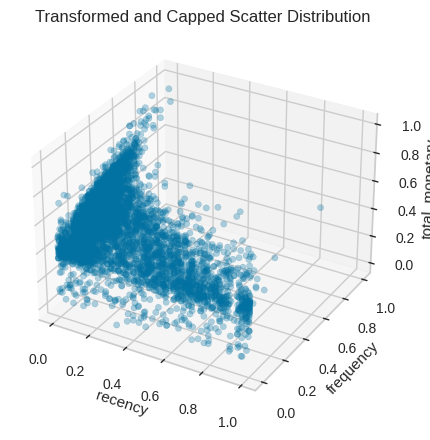

In [23]:
# 3D scatterplot - After Preprocessed
plt.figure(figsize=(5,5))

ax = plt.subplot(111, projection='3d')
ax.scatter(X['recency'], X['frequency'], X['total_monetary'],
           marker="o", alpha=.3)

ax.set_xlabel("recency")
ax.set_ylabel("frequency")
ax.set_zlabel("total_monetary")

plt.title('Transformed and Capped Scatter Distribution')
plt.show()

## **MODELING**

Proses pemodelan akan menguji jumlah klaster terpilih menggunakan model K-Means. Pengevaluasian jumlah cluster terpilih mempertimbangkan metric silhoette score, inertia dan visualisasi sebaran cluster yang terbentuk.

### **MODELING: K-MEANS**

In [24]:
# build multiple K-Means model with 2-7 centroid
KMeans_per_k = [KMeans(n_clusters=i, random_state=0, algorithm='elkan').fit(X) for i in range(2,8)]

Text(0, 0.5, 'inertia')

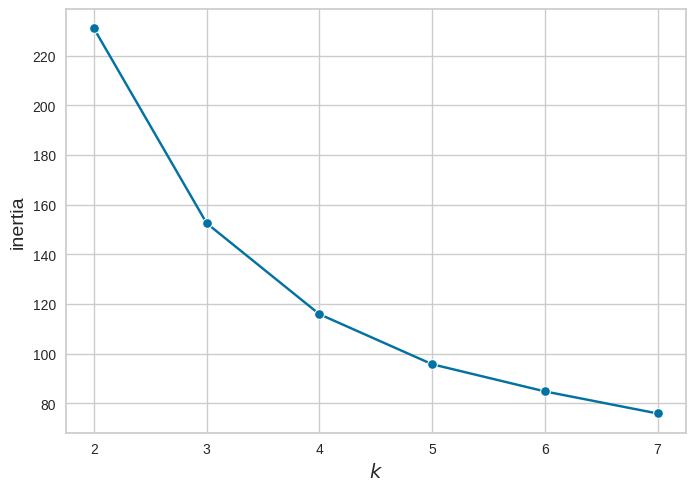

In [25]:
# elbow method - inertia
inertia_score = [model.inertia_ for model in KMeans_per_k]

sns.lineplot(x=range(2,8), y=inertia_score, marker="o")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("inertia", fontsize=14)

Text(0, 0.5, 'Silhouette score')

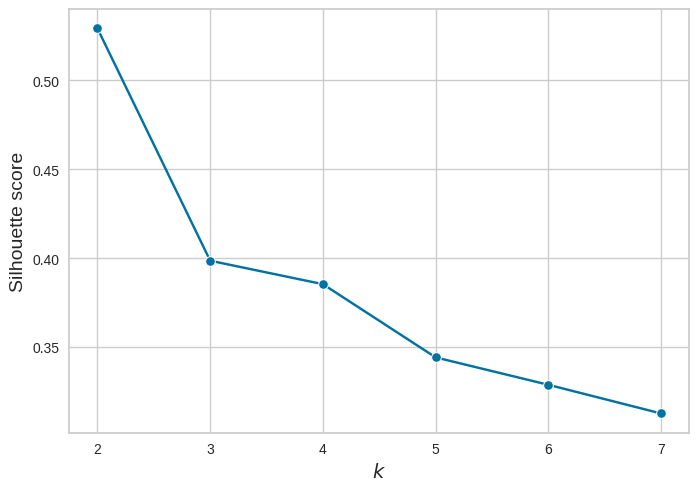

In [26]:
# sillhouette score
sill_score = [silhouette_score(X, model.labels_) for model in KMeans_per_k]

sns.lineplot(x=range(2,8), y=sill_score, marker="o")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)

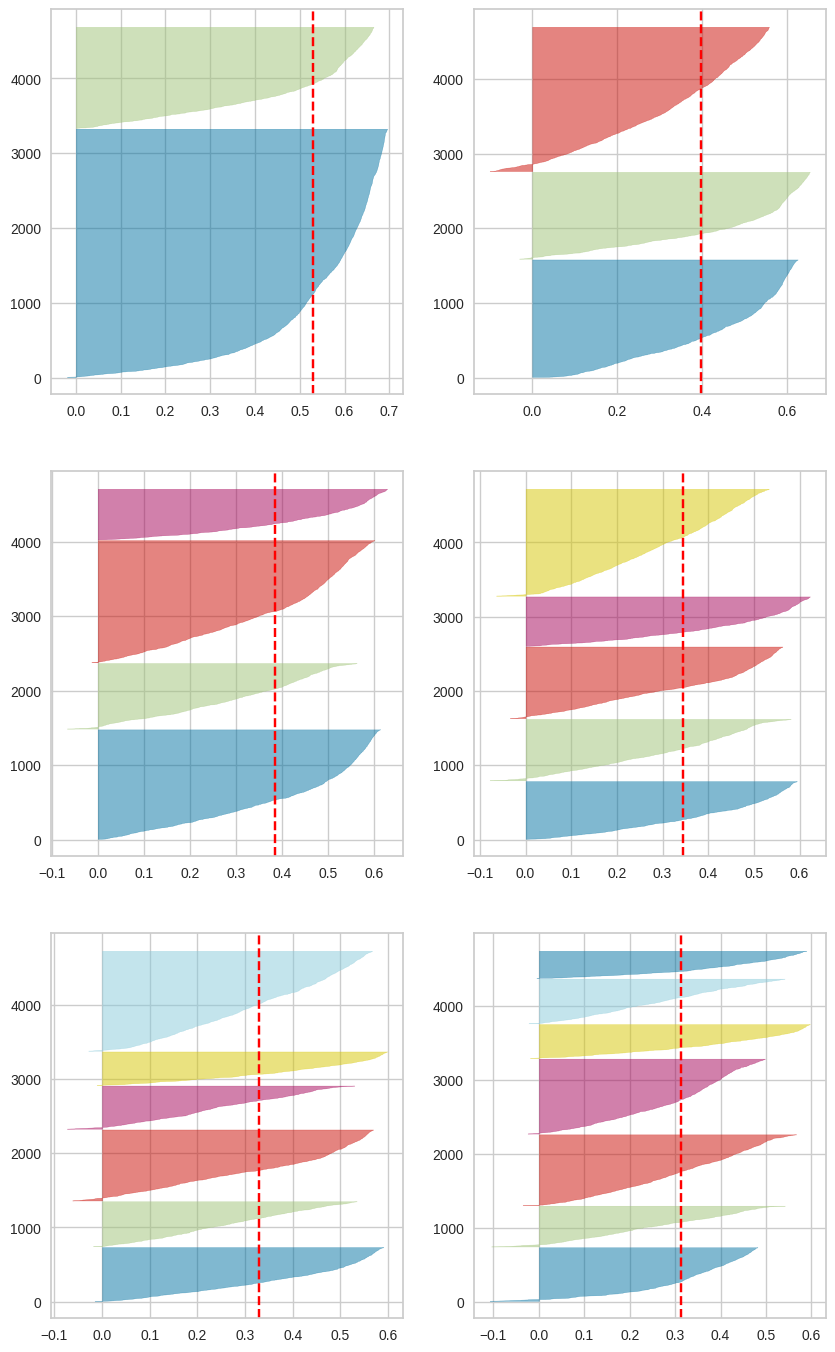

In [27]:
fig, ax = plt.subplots(3, 2, figsize=(10,17))
for i in range(2,8):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, random_state=0)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)

Berdasarkan nilai inertia, elbow method ditemukan pada nilai k=3. Hal ini juga sejalan dengan nilai dari silhoette score yang didapatkan. Dapat dikatakan k=3 merupakan jumlah cluster optimal menurut sudut pandang model K-Means. Maka selanjutnya kita akan melihat hasil pembagian cluster dengan 3 centroid, sebagai pembanding akan dilakukan pula visualisasi hasil segmentasi dengan k=4.

Meskipun k=4 bukan merupakan titik elbow pada skor inertia dan memiliki silhouette skor yang relatif rendah, tetapi kita akan coba melihat bagaimana pembagian karakteristik segmentasinya.

**K-MEANS EVALUATION**

In [28]:
# function for segmentation and visualization
def scaled_viz(n_cluster, model_cluster):
    # initiate KMeans with n_clusters
    n = n_cluster
    model = model_cluster.fit(X)

    df_scaled = X.copy()
    df_scaled['label'] = model.labels_

    # viz
    cmap = plt.get_cmap("viridis",n)

    plt.figure(figsize=(7,7))
    ax = plt.subplot(111, projection='3d')

    for i in range(0,n):
        for_vis = df_scaled[df_scaled['label']==i]
        ax.scatter(for_vis['recency'], for_vis['frequency'], for_vis['total_monetary'],
                    color=cmap(i), s=(for_vis['total_monetary'])*30, marker="o", alpha=.5, label=i)

    ax.set_xlabel("recency")
    ax.set_ylabel("frequency")
    ax.set_zlabel("total_monetary")

    plt.legend()
    plt.title('Scaled and Capped Scatter Distribution')
    plt.show()

    return df_scaled

def pairs(data):
    # viz
    sns.pairplot(data, hue='label', palette='viridis')

**Trial: 3 Klaster**

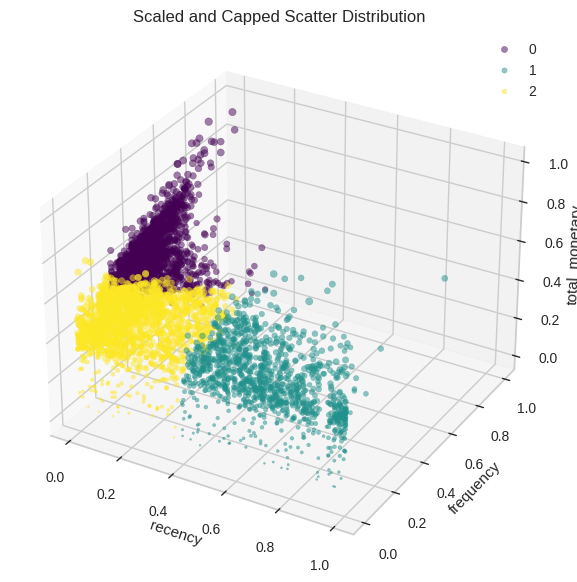

In [29]:
# K-Means 3 cluster result
n_3 = scaled_viz(n_cluster=3,
           model_cluster=KMeans(n_clusters=3, random_state=0, algorithm='elkan'))

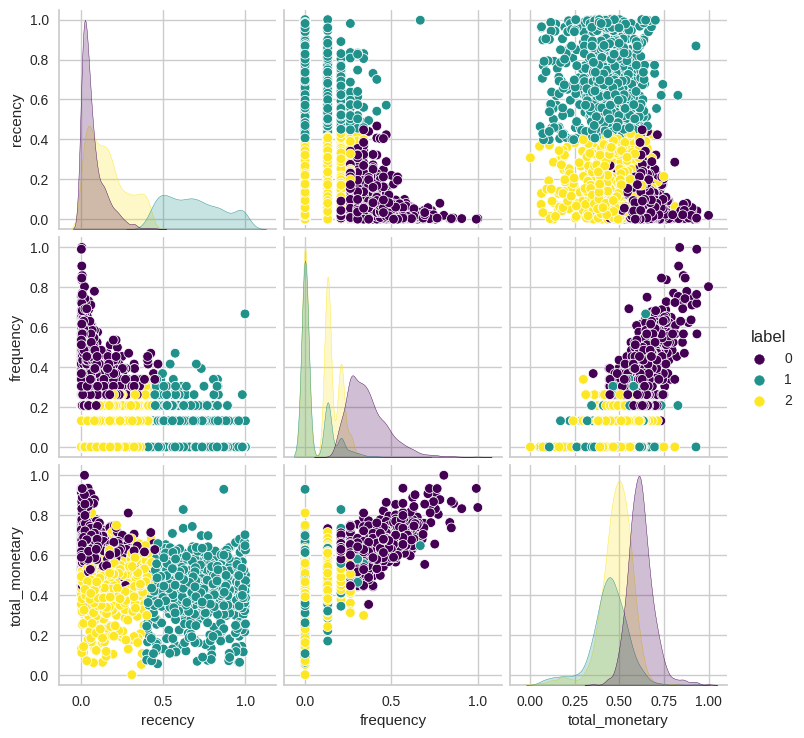

In [30]:
pairs(data=n_3)

In [31]:
n_3['label'].value_counts(normalize=True)

2    0.414044
0    0.336759
1    0.249197
Name: label, dtype: float64

**Trial: 4 klaster**

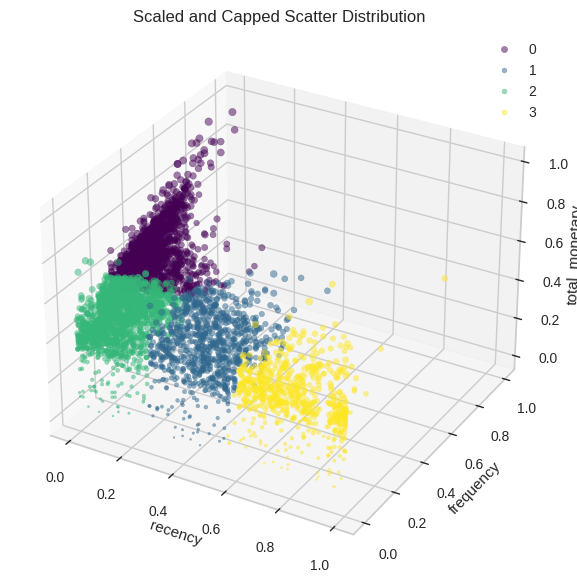

In [32]:
# K-Means 4 cluster result
n_4 = scaled_viz(n_cluster=4,
           model_cluster=KMeans(n_clusters=4, random_state=0, algorithm='elkan'))

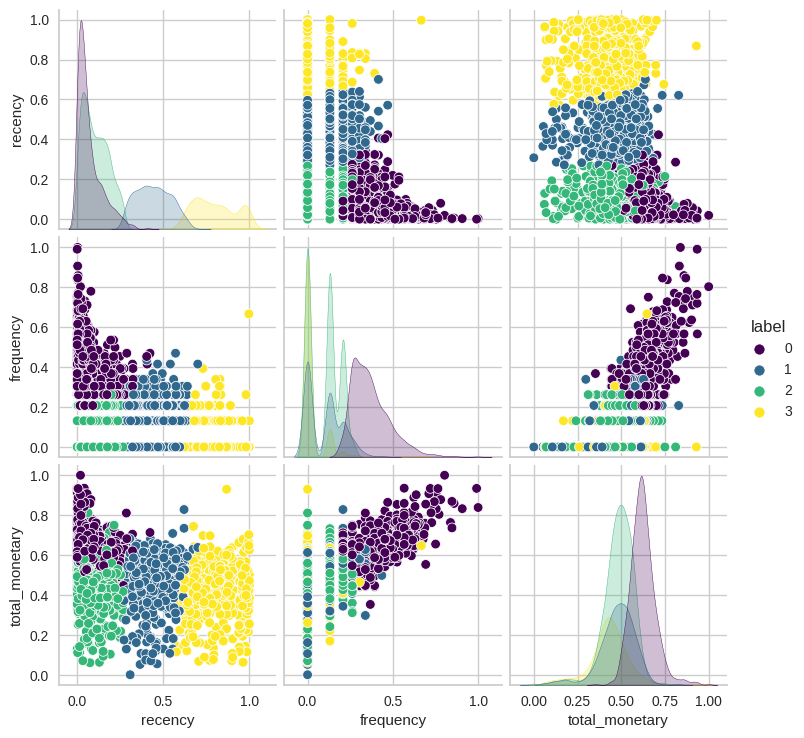

In [33]:
pairs(n_4)

In [34]:
n_4['label'].value_counts(normalize=True)

2    0.351103
0    0.314708
1    0.188611
3    0.145579
Name: label, dtype: float64

Pada perbandingan diatas, terlihat pengelompokkan menjadi 3 cluster relatif lebih rapih. Tetapi peneliti beropini jika hanya menggunakan 3 cluster saja maka karakteristik diantara clusternya masih terlalu general dan akan sedikit sulit dalam melakukan personifikasi hasil cluster terbentuk.

Secara visualisasi data, pembagian menjadi 4 cluster relatif cukup untuk memberikan personifikasi pada pelanggan.

## **EDA CLUSTER**

Pada bagian ini kita akan melihat karakteristik dari masing-masing kelompok untuk model terpilih, yaitu K-Means dengan 4 jumlah cluster.

Eksplorasi data yang akan dilakukan menggunakan value data original, bukan bentuk preprocessed-nya.

In [35]:
# initiate KMeans with 4 clusters
n = 4
model = KMeans(n_clusters=n, random_state=0, algorithm='elkan').fit(X)

df_ori = df_rfm.copy()
df_ori['label'] = model.labels_

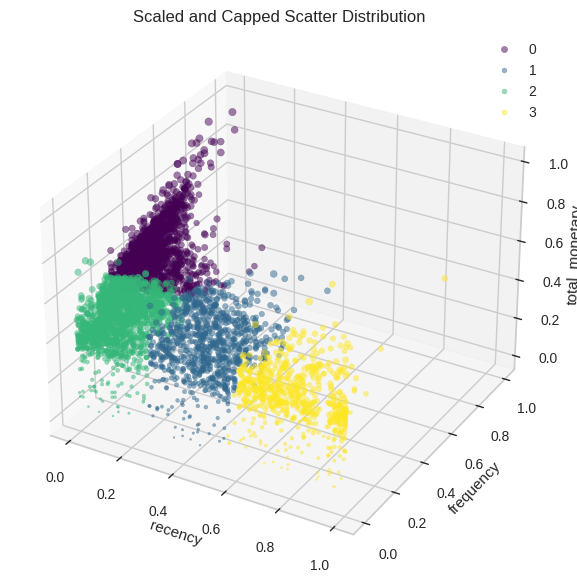

,recency,frequency,total_monetary,label
0,0.598901,0.000000,0.433869,1
1,0.574176,0.000000,0.111547,3
2,0.733516,0.000000,0.537912,3
3,0.961538,0.000000,0.192998,3
4,0.458791,0.000000,0.252556,1
...,...,...,...,...
4666,0.736264,0.000000,0.364499,3
4667,0.469780,0.000000,0.358394,1
4668,0.321429,0.000000,0.390792,1
4669,0.000000,0.512087,0.588859,0


In [36]:
# K-Means 4 cluster; Scaled and Capped Scatter Distribution
scaled_viz(n_cluster=4, model_cluster=KMeans(n_clusters=4, random_state=0, algorithm='elkan'))

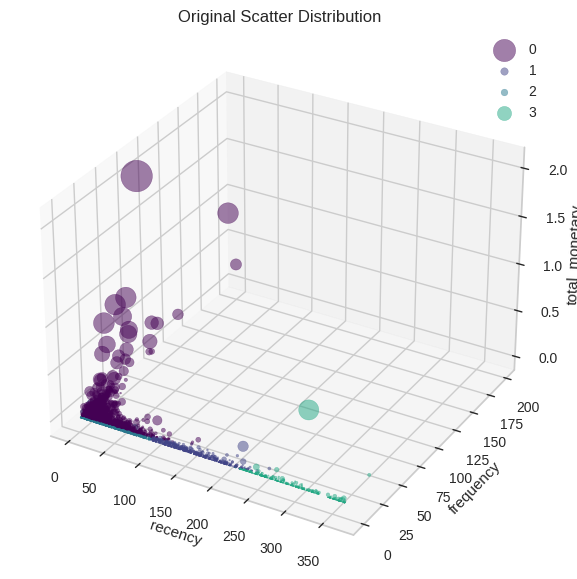

In [37]:
# K-Means 4 cluster; Original Scatter Distribution
cmap = plt.get_cmap("viridis",6)

plt.figure(figsize=(7,7))
ax = plt.subplot(111, projection='3d')

for i in range(0,n):
  for_vis = df_ori[df_ori['label']==i]
  ax.scatter(for_vis['recency'], for_vis['frequency'], for_vis['total_monetary'],
             color=cmap(i), s=for_vis['total_monetary']/40000*10, marker="o", alpha=.5, label=i)

ax.set_xlabel("recency")
ax.set_ylabel("frequency")
ax.set_zlabel("total_monetary")

plt.legend()
plt.title('Original Scatter Distribution')
plt.show()

In [38]:
# function for highlight only selected cluster
def highlight_clust_df_ori(clust_to_highlight, n_clust):
    cmap = plt.get_cmap("viridis",n_clust)

    plt.figure(figsize=(7,7))
    ax = plt.subplot(111, projection='3d')

    for i in range(0,n_clust):
        for_vis = df_ori[df_ori['label']==i]
        if i == clust_to_highlight:
            ax.scatter(for_vis['recency'], for_vis['frequency'], for_vis['total_monetary'],
                    color=cmap(i), s=for_vis['total_monetary']/40000*10, marker="o", alpha=1)
        else:
            ax.scatter(for_vis['recency'], for_vis['frequency'], for_vis['total_monetary'],
                    color='gray', s=for_vis['total_monetary']/40000*10, marker="o", alpha=.05)


    ax.set_xlabel("recency")
    ax.set_ylabel("frequency")
    ax.set_zlabel("total_monetary")

    plt.title(f'Original Scatter Distribution, Cluster {clust_to_highlight}')
    plt.show()

    display(df_ori[df_ori['label']==clust_to_highlight].describe().T)

    perc_user = len(df_ori[df_ori['label']==clust_to_highlight])/df_ori.shape[0] * 100

    rev_label = df_ori[df_ori['label']==clust_to_highlight]['total_monetary'].sum()
    total_rev = df_ori['total_monetary'].sum()
    perc_rev = rev_label/total_rev * 100

    print('\n--Proportion--')
    print("Persentase Customer: ", round(perc_user,2))
    print("Persentase Revenue: ", round(perc_rev,2))

---
**Cluster 0 - Active User**

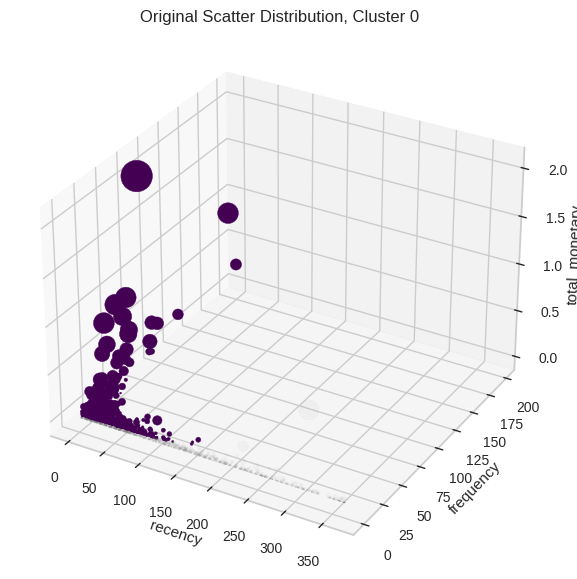

,count,mean,std,min,25%,50%,75%,max
recency,1470.0,26.408844,26.056300,1.00,8.0000,17.000,37.0000,155.00
frequency,1470.0,9.023810,11.065193,3.00,4.0000,6.000,10.0000,198.00
total_monetary,1470.0,30690.412265,85945.598215,534.73,9281.5575,15579.815,26435.1575,2061832.51
label,1470.0,0.000000,0.000000,0.00,0.0000,0.000,0.0000,0.00



--Proportion--
Persentase Customer:  31.47
Persentase Revenue:  74.86


In [39]:
# cluster 0
highlight_clust_df_ori(0, n_clust=5)

In [40]:
above_100k = len(df_ori[(df_ori['label']==0) & (df_ori['total_monetary']>100000)])
total_clust_0 = len(df_ori[(df_ori['label']==0)])

print('Jumlah spending > 100k pada label 0: ', above_100k)
print('Persentase spending > 100k pada label 0: ', round((above_100k/total_clust_0)*100,2))

Jumlah spending > 100k pada label 0:  48
Persentase spending > 100k pada label 0:  3.27


Cluster 0 memiliki karakter pengguna aktif yang berkontribusi terhadap ~75% revenue perusahaan.

Pelanggan pada cluster ini memiliki frekuensi transaksi 4 hingga 6 kali selama satu tahun terakhir. Mayoritas total spending pada cluster ini berkisar diantara 10.000 (Q1) hingga 26.000 (Q3) dolar. Diantaranya terdapat 48 (3%) pelanggan yang menghabiskan total belanja diatas 100.000 dalam 1 tahun terakhir.

Mengingat pelanggan di dalam klaster ini memiliki kontribusi besar terhadap revenue perusahaan maka strategi retain customer perlu berfokus untuk mempertahankan kepercayaan pelanggan seperti kebijakan sistem reward jika pelanggan mencapai jumlah transaksi tertentu maka akan diberikan fasilitas/merchandise spesial.

---
**Cluster 1 - Seasonal Hibernators**

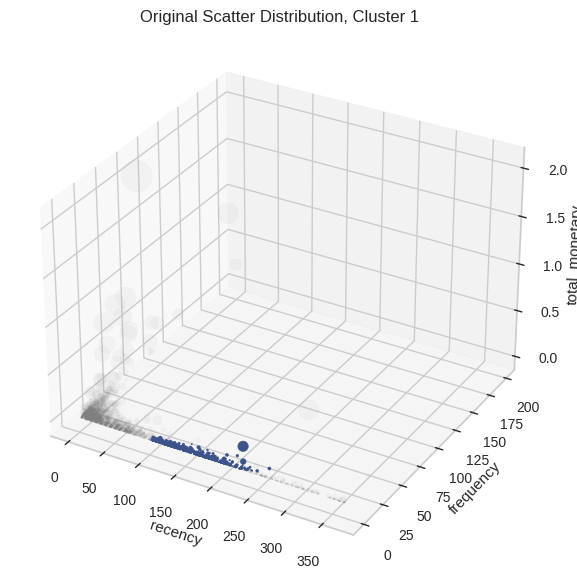

,count,mean,std,min,25%,50%,75%,max
recency,881.0,161.929625,35.570794,100.00,133.00,161.00,190.00,256.0
frequency,881.0,1.986379,1.256726,1.00,1.00,2.00,3.00,12.0
total_monetary,881.0,4994.405948,9474.644868,5.97,1332.27,2940.74,6073.14,230408.4
label,881.0,1.000000,0.000000,1.00,1.00,1.00,1.00,1.0



--Proportion--
Persentase Customer:  18.86
Persentase Revenue:  7.3


In [41]:
highlight_clust_df_ori(1, n_clust=5)

Pelanggan pada kelompok ini merupakan customer yang tidak melakukan transaksi lebih dari 3 bulan terakhir. Bila ditinjau dari karakter berbelanja, rerata pelanggan pada klaster ini memiliki frekuensi 2 kali belanja dengan total spending cukup besar 1.332 (Q1) hingga 6.073 (Q3).

Diasumsikan, anggota klaster ini merupakan pemborong musiman yang hadir dalam frekuensi tertentu dan melakukan one-time big purchase. Saran strategi yang dapat diterapkan pada anggota klaster ini ialah memberikan ajakan atau notifikasi belanja dengan potongan harga tertentu serta waktu yang terbatas agar menimbulkan efek urgensi/fomo atau menawarkan kerjasama dalam kurun waktu tertentu.

---
**Cluster 2 - Freshman**

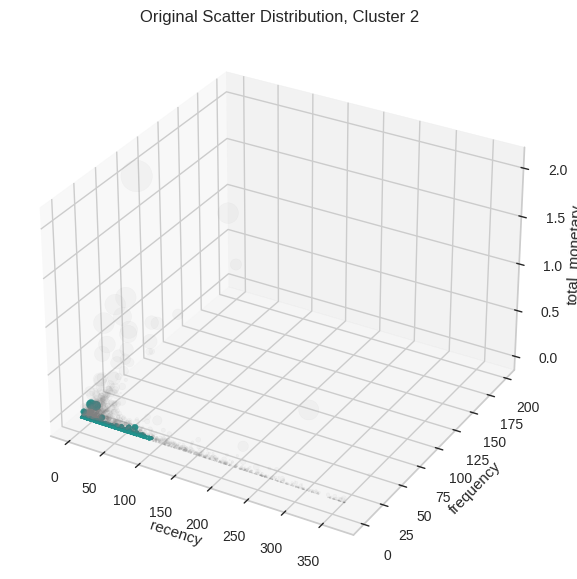

,count,mean,std,min,25%,50%,75%,max
recency,1640.0,39.853659,26.775578,1.00,16.00,36.00,60.5000,101.00
frequency,1640.0,1.881098,0.848433,1.00,1.00,2.00,3.0000,4.00
total_monetary,1640.0,4796.690195,8302.504170,12.86,1642.45,3203.81,6011.0275,184880.85
label,1640.0,2.000000,0.000000,2.00,2.00,2.00,2.0000,2.00



--Proportion--
Persentase Customer:  35.11
Persentase Revenue:  13.05


In [42]:
# cluster 2
highlight_clust_df_ori(2, n_clust=5)

Anggota pada cluster ini memiliki ciri-ciri pengguna baru ditandai dengan recency yang kecil dan rerata frekuensi belanja dibawah 2.

Tujuan intervensi pada kelompok ini ialah untuk men-encourage pelanggan untuk belanja dan menumbuhkan rasa kepercayaan pelanggan. Beberapa fasilitas seperti kupon potongan harga, bebas biaya pengiriman dan fasilitas lain dapat diberikan hingga pelanggan tersebut naik ke klaster 0.

---
**Cluster 3 - Churned**

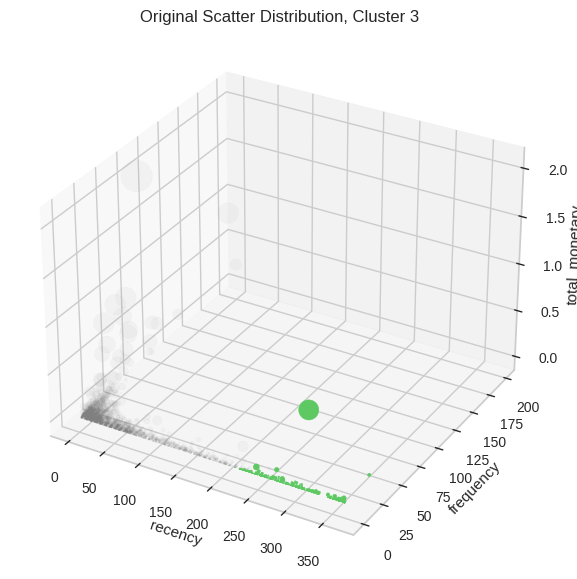

,count,mean,std,min,25%,50%,75%,max
recency,680.0,292.004412,43.533695,209.00,254.00,287.00,326.0000,365.0
frequency,680.0,1.282353,1.423446,1.00,1.00,1.00,1.0000,34.0
total_monetary,680.0,4246.596221,32592.551973,13.27,772.64,1451.61,2932.7125,840113.8
label,680.0,3.000000,0.000000,3.00,3.00,3.00,3.0000,3.0



--Proportion--
Persentase Customer:  14.56
Persentase Revenue:  4.79


In [43]:
# cluster 3
highlight_clust_df_ori(3, n_clust=5)

Karakter anggota pada kelompok ini memiliki nilai terendah dari keseluruhan cluster: sumbangsih revenue, frekuensi transaksi dan nilai recency.

Jikapun ingin memberikan one last push effort seperti pemberian diskon, perusahaan perlu memanfaatkan kesempatan tersebut untuk engage terhadap customer dan mendapatkan feedback atas ketidakpuasan pelanggan.



## **KESIMPULAN**

Pada notebook ini telah dilakukan segmentasi pelanggan menggunakan metrics RFM. Adapun model yang dipilih ialah K-Means clustering dengan jumlah cluster k=4. Berikut merupakan rekomendasi kebijakan untuk setiap cluster yang terbentuk:

- **Cluster 0 - Active User:** Sistem reward jika sudah mencapai jumlah transaksi tertentu.
- **Cluster 1 - Seasonal Hibernator:** Menawarkan flash sale/upselling/cross-selling untuk menimbulkan efek urgensi. Alternatif lain dapat menawarkan kerjasama dalam kurun waktu tertentu.
- **Cluster 2 - Freshman:** Beberapa fasilitas seperti kupon potongan harga, bebas biaya pengiriman dan fasilitas lain dapat diberikan hingga pelanggan tersebut naik ke klaster 0.
- **Cluster 3 - Churned:** Jikapun ingin memberikan one last push effort seperti pemberian diskon, perusahaan perlu memanfaatkan kesempatan tersebut untuk engage terhadap customer dan mendapatkan feedback atas ketidakpuasan pelanggan.

Adapun improvisasi lebih lanjut yang dapat dilakukan pada project ini ialah: memperluas rentang periode sample. Mengingat salah satu keterbatasan data yang digunakan hanya memiliki rentang 1 tahun maka behavior dari pelanggan tidak maksimal tergambarkan pada penelitian ini. Hal lainnya, semenjak metrics yang digunakan ialah RFM, kita tidak dapat meninjau behavior cluster yang terbentuk berdasarkan data demografis masing-masing pelanggan.